Epoch 0 - Generator Loss: 1.2415, Discriminator Loss: 0.3846
1/1 [==============================] - 0s 88ms/step


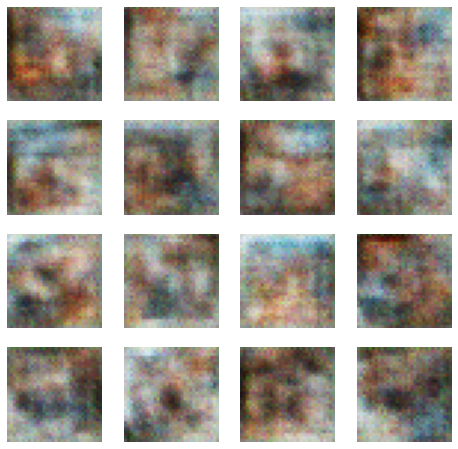

Epoch 10 - Generator Loss: 1.3146, Discriminator Loss: 0.3234
1/1 [==============================] - 0s 17ms/step


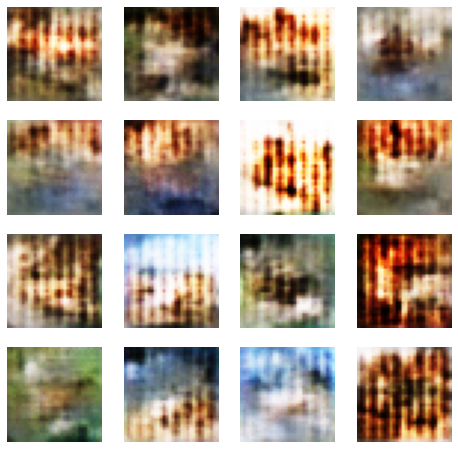

Epoch 20 - Generator Loss: 1.6524, Discriminator Loss: 0.3653
1/1 [==============================] - 0s 19ms/step


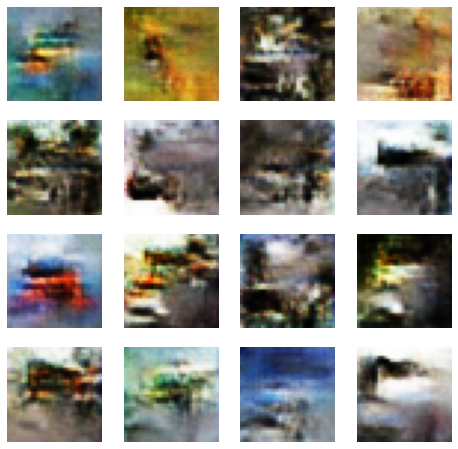

Epoch 30 - Generator Loss: 2.2662, Discriminator Loss: 0.1790
1/1 [==============================] - 0s 32ms/step


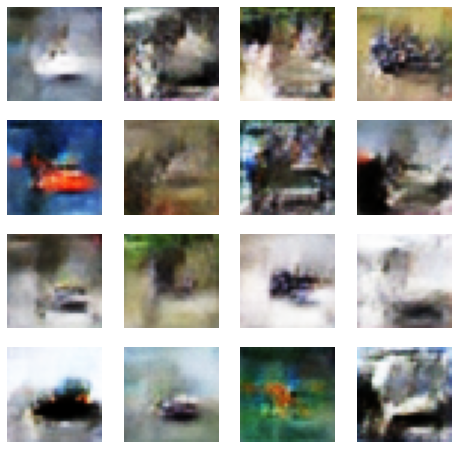

Epoch 40 - Generator Loss: 1.6762, Discriminator Loss: 0.2074
1/1 [==============================] - 0s 29ms/step


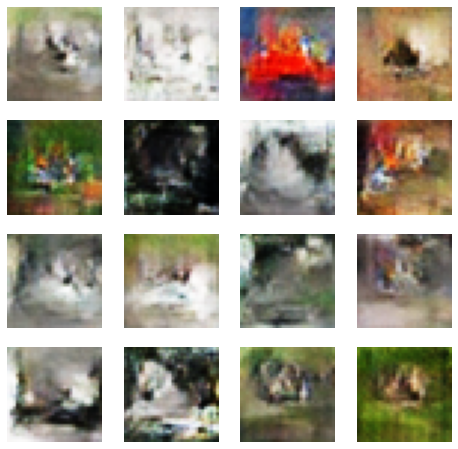

Epoch 50 - Generator Loss: 2.8427, Discriminator Loss: 0.2242
1/1 [==============================] - 0s 34ms/step


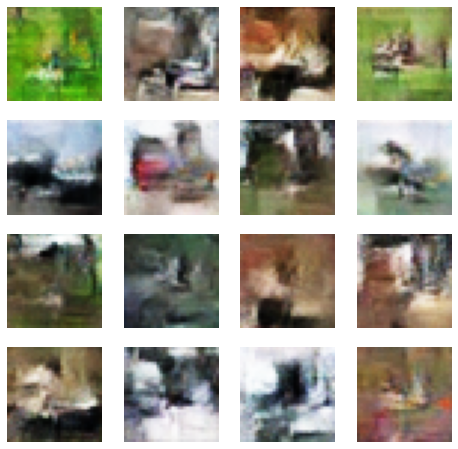

Epoch 60 - Generator Loss: 2.6687, Discriminator Loss: 0.3050
1/1 [==============================] - 0s 29ms/step


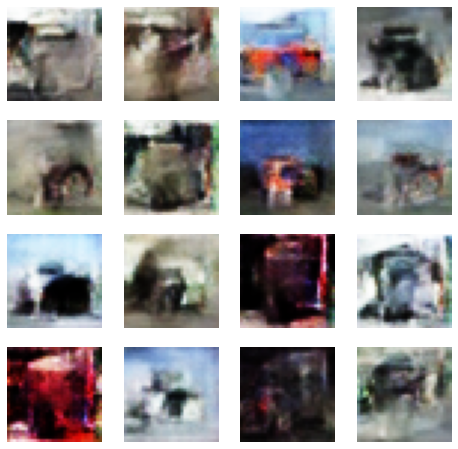

Epoch 70 - Generator Loss: 2.8630, Discriminator Loss: 0.1499
1/1 [==============================] - 0s 27ms/step


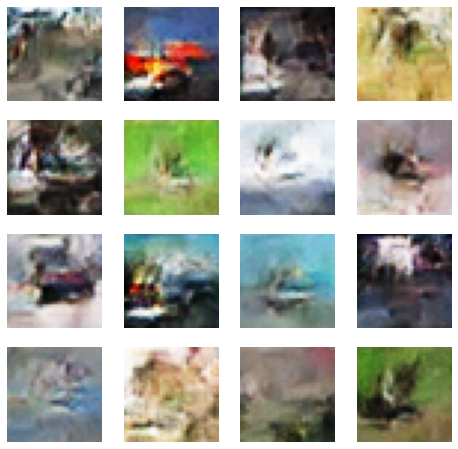

Epoch 80 - Generator Loss: 3.1060, Discriminator Loss: 0.1653
1/1 [==============================] - 0s 31ms/step


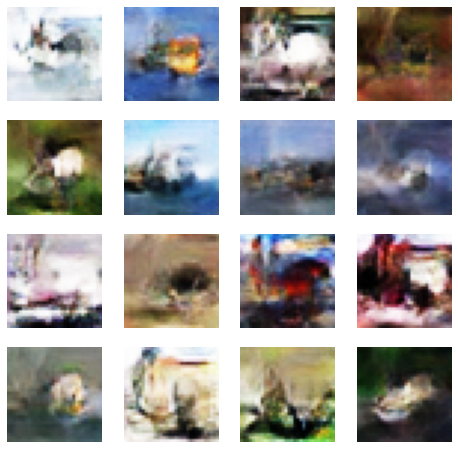

Epoch 90 - Generator Loss: 2.2194, Discriminator Loss: 0.1514
1/1 [==============================] - 0s 21ms/step


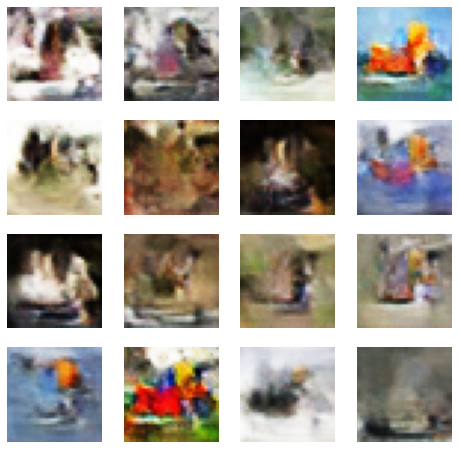

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
(train_images, _), (test_images, _) = keras.datasets.cifar10.load_data()

# Normalize the images to [-1, 1]
train_images = (train_images.astype("float32") - 127.5) / 127.5
test_images = (test_images.astype("float32") - 127.5) / 127.5

# Convert to tensor
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(10000).batch(256)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).batch(256)
latent_dim = 128

# Generator model
generator = keras.Sequential(
    [
        layers.Dense(8*8*128, input_shape=(latent_dim,), use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding="same", use_bias=False, activation="tanh"),
    ],
    name="generator",
)

# Discriminator model
discriminator = keras.Sequential(
    [
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding="same", input_shape=(32, 32, 3)),
        layers.LeakyReLU(),
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
# Binary cross-entropy loss
bce_loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)

# Generator optimizer
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Discriminator optimizer
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
@tf.function
def train_step(real_images):
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)

        real_logits = discriminator(real_images, training=True)
        fake_logits = discriminator(fake_images, training=True)

        gen_loss = bce_loss_fn(tf.ones_like(fake_logits), fake_logits)
        disc_loss = bce_loss_fn(tf.ones_like(real_logits), real_logits)
        disc_loss += bce_loss_fn(tf.zeros_like(fake_logits), fake_logits)
        disc_loss *= 0.5

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss


def train(dataset, epochs):
    for epoch in range(epochs):
        for batch in dataset:
            gen_loss, disc_loss = train_step(batch)

        # Print the losses every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch {epoch} - Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}")

            # Generate some sample images
            generate_images(generator, epoch)

            
def generate_images(model, epoch):
    noise = tf.random.normal([16, latent_dim])
    generated_images = model.predict(noise)

    # Rescale the images to [0, 1]
    generated_images = (generated_images + 1) / 2.0

    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    axs = axs.flatten()

    for i in range(16):
        axs[i].imshow(generated_images[i])
        axs[i].axis("off")

    plt.savefig(f"epoch_{epoch}.png")
    plt.show()


# Train the GAN
epochs = 100
train(train_dataset, epochs)
